# Content
* [1  Problem description](#1)
    * [1.1  Testbed description](#1.1)
    * [1.2  Business problem](#1.2)
    * [1.3  Metrics](#1.3)
    * [1.4  Data description](#1.4)
    * [1.5  Strucuture of data](#1.5)
* [2  Data analysis](#2)
    * [2.1  Data loading](#2.1)
    * [2.2  Summarized information about data](#2.2)
        * [2.2.1  Number of experiements, sizes of datasets](#2.2.1)
        * [2.2.2  Aggregated data for experiments](#2.2.2)
    * [2.3  Signal analysis](#2.3)        
        * [2.3.1  Descriptive statistics](#2.3.1)
        * [2.3.2  Signal plots](#2.3.2)
        * [2.3.3  Pairwise Correlations](#2.3.3)
        * [2.3.4  Pairplot](#2.3.4)
        * [2.3.5  Distribution plot](#2.3.5)

<a id="1"></a>
# 1 Problem description

<a id="1.1"></a>
## 1.1 Testbed description  

![Стенд](https://github.com/waico/SKAB/blob/master/docs/pictures/testbed.png?raw=true)

Front panel and composition of the water circulation, control and monitoring systems: 1,2 - solenoid valve (amount - 1); 3 - a tank with water (1); 4 - a water pump (1); 5 - emergency stop button (1); 6 - electric motor (1); 7 - inverter (1); 8 - compactRIO (1); 9 - a mechanical lever for shaft misalignment (1). Not shown parts - vibration sensor (2); pressure meter (1); flow meter (1); thermocouple (2).

<a id="1.2"></a>
## 1.2 Business problem

The main advantages of anomaly detection in the operation of equipment:
- Reducing equipment maintenance costs
- Optimization of terms and duration of repair work
- Reducing the probability of failures

<a id="1.3"></a>
## 1.3 Metrics

When an anomaly detection problem is formulated, the classification problem is primarily solved. It is proposed to use the following metrics to evaluate the perfomance of the algorithms:
- False Alarm Rate
$$FAR = \frac{FP}{FP+TN}$$
- Missing Alarm Rate
$$MAR = \frac{FN}{TP+FN}$$

Also, to compare the results of the algorithm, you can consider the metrics described in:
https://tsad.readthedocs.io/en/latest/Evaluating.html 

<a id="1.4"></a>
## 1.4 Data description

Each file represents one experiment and contains one anomaly (the exception is the anomaly-free file, which does not contain any anomalies). The dataset is a multivariate time series collected from testbed sensors. The data folder contains the datasets from the test. Data Folder Structure:

1. anomaly-free - Data obtained from the experiments with normal mode
2. valve1 - Data obtained from the experiments with closing the valve at the outlet of the flow from the pump.
3. valve2 - Data obtained from the experiments with closing the valve at the flow inlet to the pump.
4. other - Data obtained from the other experiments 
> - 1.csv  Simulation of fluid leaks and fluid additions         
> - 2.csv  Simulation of fluid leaks and fluid additions
> - 3.csv  Simulation of fluid leaks and fluid additions
> - 4.csv  Simulation of fluid leaks and fluid additions         
> - 5.csv  Sharply behavior of rotor imbalance
> - 6.csv  Linear behavior of rotor imbalance
> - 7.csv  Step behavior of rotor imbalance
> - 8.csv  Dirac delta function behavior of rotor imbalance
> - 9.csv  Exponential behavior of rotor imbalance
> - 10.csv The slow increase in the amount of water in the circuit
> - 11.csv The sudden increase in the amount of water in the circuit
> - 12.csv Draining water from the tank until cavitation
> - 13.csv Two-phase flow supply to the pump inlet (cavitation)
> - 14.csv Water supply of increased temperature

<a id="1.5"></a>
## 1.5 Data structure

Columns in each data file are following:
* datetime - Represents dates and times of the moment when the value is written to the database (YYYY-MM-DD hh:mm:ss)
* Accelerometer1RMS - Shows a vibration acceleration (Amount of g units)
* Accelerometer2RMS - Shows a vibration acceleration (Amount of g units)
* Current - Shows the amperage on the electric motor (Ampere)
* Pressure - Represents the pressure in the loop after the water pump (Bar)
* Temperature - Shows the temperature of the engine body (The degree Celsius)
* Thermocouple - Represents the temperature of the fluid in the circulation loop (The degree Celsius)
* Voltage - Shows the voltage on the electric motor (Volt)
* RateRMS - Represents the circulation flow rate of the fluid inside the loop (Liter per minute)
* anomaly - Shows if the point is anomalous (0 or 1)
* changepoint - Shows if the point is a changepoint for collective anomalies (0 or 1)

<a id="2"></a>
# 2 Data analysis

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

import warnings
warnings.filterwarnings('ignore')

<a id="2.1"></a>
## 2.1 Data loading

In [2]:
all_files = []
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(f'{root}/{file}')

print("Список файлов:")
all_files.sort()
display(all_files)

Список файлов:


['../data/anomaly-free/anomaly-free.csv',
 '../data/other/1.csv',
 '../data/other/10.csv',
 '../data/other/11.csv',
 '../data/other/12.csv',
 '../data/other/13.csv',
 '../data/other/14.csv',
 '../data/other/2.csv',
 '../data/other/3.csv',
 '../data/other/4.csv',
 '../data/other/5.csv',
 '../data/other/6.csv',
 '../data/other/7.csv',
 '../data/other/8.csv',
 '../data/other/9.csv',
 '../data/valve1/0.csv',
 '../data/valve1/1.csv',
 '../data/valve1/10.csv',
 '../data/valve1/11.csv',
 '../data/valve1/12.csv',
 '../data/valve1/13.csv',
 '../data/valve1/14.csv',
 '../data/valve1/15.csv',
 '../data/valve1/2.csv',
 '../data/valve1/3.csv',
 '../data/valve1/4.csv',
 '../data/valve1/5.csv',
 '../data/valve1/6.csv',
 '../data/valve1/7.csv',
 '../data/valve1/8.csv',
 '../data/valve1/9.csv',
 '../data/valve2/0.csv',
 '../data/valve2/1.csv',
 '../data/valve2/2.csv',
 '../data/valve2/3.csv']

In [3]:
other_description = {'1.csv':'Simulation of fluid leaks and fluid additions',
'2.csv':'Simulation of fluid leaks and fluid additions',
'3.csv':'Simulation of fluid leaks and fluid additions',
'4.csv':'Simulation of fluid leaks and fluid additions',
'5.csv':'Sharply behavior of rotor imbalance',
'6.csv':'Linear behavior of rotor imbalance',
'7.csv':'Step behavior of rotor imbalance',
'8.csv':'Dirac delta function behavior of rotor imbalance',
'9.csv':'Exponential behavior of rotor imbalance',
'10.csv':'The slow increase in the amount of water in the circuit',
'11.csv':'The sudden increase in the amount of water in the circuit',
'12.csv':'Draining water from the tank until cavitation',
'13.csv':'Two-phase flow supply to the pump inlet (cavitation)',
'14.csv':'Water supply of increased temperature',
                     }

In [4]:
# Группировка данных по типу аномалии
anomaly_free_data = pd.read_csv('../data/anomaly-free/anomaly-free.csv',
                                sep=';', index_col='datetime', parse_dates=True)
valve1_data = {file.split('/')[-1]: pd.read_csv(file, sep=';', index_col='datetime', parse_dates=True) for file
               in all_files if 'valve1' in file}
valve2_data = {file.split('/')[-1]: pd.read_csv(file, sep=';', index_col='datetime', parse_dates=True) for file
               in all_files if 'valve2' in file}
other_data = {file.split('/')[-1]: pd.read_csv(file, sep=';', index_col='datetime', parse_dates=True) for file 
              in all_files if 'other' in file}

<a id="2.2"></a>
## 2.2 Summarized information about the data
This section focuses on general information about data and contains the following subsections:
* Number of experiments, dataset sizes
* Aggregated experiment data
* Descriptive statistics
* Gaps and outliers in the data
* Measurement resolution
* Pairwise correlations
* Determination of the operation modes: transfer mode, work mode, stop mode

<a id="2.2.1"></a>
### 2.2.1 Number of experiments, dataset sizes
To get started, you can look at the number of experiments in each group, the first few rows in these experiments, and the dimension of the data in the experiments.

In [5]:
display(Markdown('<br>__Number of experiments in each group:__'))
print('Experiments with closing the valve at the outlet of the pump:', len(valve1_data))
print('Experiments with closing the valve at the inlet flow to the pump:', len(valve2_data))
print('Other experiments:', len(other_data))
print('Datasets without anomalies: 1')

display(Markdown('<br><br>__Dataset without anomalies__'))
display(anomaly_free_data.head(3))
print('Dataset size:', anomaly_free_data.shape)

display(Markdown('<br><br>__The first dataset from the group "Other experiments"__'))
display(other_data['1.csv'].head(3))
print('Dataset size:', other_data['1.csv'].shape)

<br>__Number of experiments in each group:__

Experiments with closing the valve at the outlet of the pump: 16
Experiments with closing the valve at the inlet flow to the pump: 4
Other experiments: 14
Datasets without anomalies: 1


<br><br>__Dataset without anomalies__

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-02-08 13:30:47,0.202394,0.275154,2.16975,0.382638,90.6454,26.8508,238.852,122.664
2020-02-08 13:30:48,0.203153,0.277857,2.07999,-0.273216,90.7978,26.8639,227.943,122.338
2020-02-08 13:30:50,0.202054,0.275790,2.52577,0.382638,90.7730,26.8603,223.486,121.338


Dataset size: (9405, 8)


<br><br>__The first dataset from the group "Other experiments"__

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0,0.0
2020-03-01 15:44:07,0.082724,0.132378,1.12118,-0.273216,92.0144,22.2577,221.250,76.9806,0.0,0.0
2020-03-01 15:44:08,0.081648,0.139038,1.93242,0.054711,92.2413,22.2748,236.615,76.0197,0.0,0.0


Dataset size: (745, 10)


<a id="2.2.2"></a>
### 2.2.2 Aggregated data for experiments
To compare different experiments, we will collect aggregated information for each experiment and create a pivot table that includes the following fields:
* type of experiment
* experiment number
* description of the experiment
* experiment duration
* number of lines
* percentage of rows with anomalies
* number of state change points
* Main time between samples, seconds
* Percent of main sample frequency among all samples
* Number of time gaps between samples


In [6]:
def experiment_describe(data, anomaly_type, description, experiment=0):
    start_time = data.index.min()
    finish_time = data.index.max()
    duration = finish_time - start_time
    
    nas = data.isna().sum().sum()
    
    rows = data.shape[0]
    if 'anomaly' in data.columns:
        anomaly_percent = np.round(data['anomaly'].mean() * 100, 2)
        changepoints = data['changepoint'].sum()
    else:
        anomaly_percent = 0
        changepoints = 0  
    
    
    dif_time = data.index.to_series().diff().dropna().dt.seconds.value_counts()
    main_sample_rate = dif_time.index[0]
    percent_of_main_sample_rate = round(dif_time.values[0]/dif_time.sum() * 100,2)
    number_of_gaps = dif_time[dif_time.index > main_sample_rate*3].sum()
    
    
    columns = ['anomaly_type', 'experiment', 'description', 'duration', 'rows', 'anomaly_percent', 'changepoints',
               'Nas', 'Main time between samples, seconds', 'Percent of main sample frequency among all samples', 
               'Number of gaps']
    values = np.array([anomaly_type, experiment, description, duration, rows, anomaly_percent, changepoints, nas,
                       main_sample_rate, percent_of_main_sample_rate,number_of_gaps]).reshape(1, -1)
    
    describe_df = pd.DataFrame(columns=columns, data=values)
    return describe_df


experiment = '1.csv'
display(Markdown('<br>__An example of aggregated information for the experiment with the closing of the outlet valve__<br><br>'))
display(experiment_describe(valve1_data[experiment], 'value1', 'Closing the valve downstream of the pump', experiment))

<br>__An example of aggregated information for the experiment with the closing of the outlet valve__<br><br>

,anomaly_type,experiment,description,duration,rows,anomaly_percent,changepoints,Nas,"Main time between samples, seconds",Percent of main sample frequency among all samples,Number of gaps
0,value1,1.csv,Closing the valve downstream of the pump,0 days 00:20:00,1145,35.11,4.0,0,1,95.1,0


In [7]:
def get_summary_table():
    df = experiment_describe(anomaly_free_data, 'anomaly_free', 'Normal mode')
    
    for experiment in valve1_data:
        df = pd.concat([df, experiment_describe(valve1_data[experiment], 'valve1', 
                                                'Closing the valve downstream of the pump', experiment)])
        
    for experiment in valve2_data:
        df = pd.concat([df, experiment_describe(valve2_data[experiment], 'valve2',
                                                'Closing the valve at the inlet flow to the pump', experiment)])
        
    for experiment in other_data:
        df = pd.concat([df, experiment_describe(other_data[experiment], 'other', other_description[experiment], experiment)])
    
    df.index = [x for x in range(df.shape[0])]
    return df

summary_table = get_summary_table()
display(Markdown('<br>__Summary table for all experiments__<br><br>'))
display(summary_table)

<br>__Summary table for all experiments__<br><br>

,anomaly_type,experiment,description,duration,rows,anomaly_percent,changepoints,Nas,"Main time between samples, seconds",Percent of main sample frequency among all samples,Number of gaps
0,anomaly_free,0,Normal mode,0 days 02:46:00,9405,0,0,0,1,94.09,0
1,valve1,0.csv,Closing the valve downstream of the pump,0 days 00:19:59,1147,34.96,4.0,0,1,95.38,0
2,valve1,1.csv,Closing the valve downstream of the pump,0 days 00:20:00,1145,35.11,4.0,0,1,95.1,0
3,valve1,10.csv,Closing the valve downstream of the pump,0 days 00:19:59,1146,34.99,4.0,0,1,95.28,0
4,valve1,11.csv,Closing the valve downstream of the pump,0 days 00:20:00,1141,34.97,4.0,0,1,94.74,0
5,valve1,12.csv,Closing the valve downstream of the pump,0 days 00:20:00,1140,35.0,4.0,0,1,94.64,0
6,valve1,13.csv,Closing the valve downstream of the pump,0 days 00:19:59,1140,35.0,4.0,0,1,94.73,0
7,valve1,14.csv,Closing the valve downstream of the pump,0 days 00:19:59,1139,35.03,4.0,0,1,94.64,0
8,valve1,15.csv,Closing the valve downstream of the pump,0 days 00:20:00,1150,35.13,4.0,0,1,95.56,0
9,valve1,2.csv,Closing the valve downstream of the pump,0 days 00:19:59,1075,31.35,3.0,0,1,95.25,1


__From this table, the following can be noted:__
* The target time for experiments is about 20 minutes, for anomaly_free the time was 2 hours 46 minutes
* The percentage of time with an abnormal mode is in the range from 25.83% to 57.74%, but for the main part, this value is in the region of 35%
* For most experiments, 4 state change points are recorded
* np.NaN values are missing in the data

<a id="2.3"></a>
## 2.3 Signal analysis

In [8]:
# Join datasets
all_data = pd.concat(([anomaly_free_data] + list(valve1_data.values()) + list(valve2_data.values()) + list(other_data.values())),
                     0).sort_index().drop_duplicates()

<a id="2.3.1"></a>
### 2.3.1 Descriptive statistics
To further familiarize yourself with the data, you can display descriptive statistics for one of the experiments.
They include the following fields:
* count - number of records that are not gaps (np.NaN)
* minimum, average, maximum values, median and 25 75 percentiles
* standard deviation

In [9]:
display(all_data.iloc[:,:-2].describe().T)

,count,mean,std,min,25%,50%,75%,max
Accelerometer1RMS,46325.0,0.129101,0.127090,0.015752,0.027429,0.080213,0.215613,0.722747
Accelerometer2RMS,46325.0,0.162523,0.145193,0.015505,0.040393,0.129644,0.268536,0.800498
Current,46325.0,1.650803,0.793768,0.149842,0.977756,1.362620,2.472350,3.318370
Pressure,46325.0,0.079636,0.259709,-1.257000,0.054711,0.054711,0.382638,1.694350
Temperature,46325.0,79.270449,9.415046,65.089000,69.480600,84.876400,88.609400,95.011400
Thermocouple,46325.0,26.556955,2.558407,22.020900,24.643500,25.547900,29.145100,33.415100
Voltage,46325.0,229.594084,10.950017,200.744000,223.591000,229.876000,235.943000,255.324000
Volume Flow RateRMS,46325.0,75.324189,45.587849,0.555512,32.000000,72.000000,126.000000,133.688000


In [10]:
columns = anomaly_free_data.columns
mean_table = pd.DataFrame(index=[x + ' mean' for x in columns])
mean_table['anomaly free'] = anomaly_free_data.describe().loc['mean'].values
mean_table['valve1[1.csv]'] = valve1_data['1.csv'][columns].describe().loc['mean'].values
mean_table['valve2[1.csv]'] = valve2_data['1.csv'][columns].describe().loc['mean'].values
mean_table['other[1.csv]'] = other_data['1.csv'][columns].describe().loc['mean'].values

std_table = pd.DataFrame(index=[x + ' std' for x in columns])
std_table['anomaly free'] = anomaly_free_data.describe().loc['std'].values
std_table['valve1[1.csv]'] = valve1_data['1.csv'][columns].describe().loc['std'].values
std_table['valve2[1.csv]'] = valve2_data['1.csv'][columns].describe().loc['std'].values
std_table['other[1.csv]'] = other_data['1.csv'][columns].describe().loc['std'].values

std_mean_table = pd.concat([mean_table, std_table,])
display(std_mean_table)

,anomaly free,valve1[1.csv],valve2[1.csv],other[1.csv]
Accelerometer1RMS mean,0.212604,0.026868,0.027663,0.080549
Accelerometer2RMS mean,0.268407,0.040045,0.040037,0.131089
Current mean,2.403010,0.979026,0.976845,1.569378
Pressure mean,0.111266,0.074473,0.048541,0.054711
Temperature mean,89.472308,73.713523,67.895174,92.567708
Thermocouple mean,28.474310,25.740027,24.265096,22.237863
Voltage mean,228.647173,231.413459,230.143218,230.246807
Volume Flow RateRMS mean,125.237471,31.566819,31.472275,76.157459
Accelerometer1RMS std,0.004740,0.000313,0.000333,0.001167
Accelerometer2RMS std,0.003989,0.000988,0.001086,0.003030


__From this table, the following points can be distinguished:__
* The average value of vibration acceleration for anomaly free is almost an order of magnitude higher than for experiments with closing inlet and outlet valves (valve1[0], valve2[0])
* The average water flow rate for anomaly free is 4 times higher than for experiments with closing inlet and outlet valves (valve1[0], valve2[0])
* Average values of temperature, pressure, current, thermocouple for anomaly free are higher than for experiments with closing inlet and outlet valves (valve1[0], valve2[0])

<a id="2.3.2"></a>
### 2.3.2 Signal plots

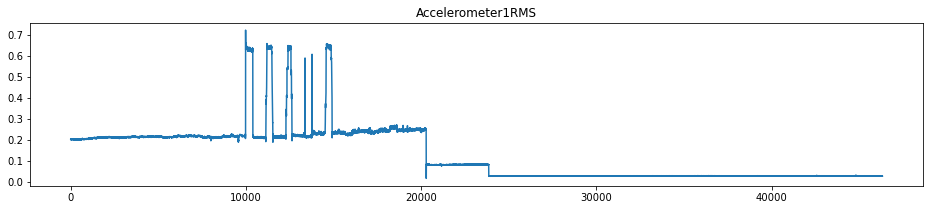

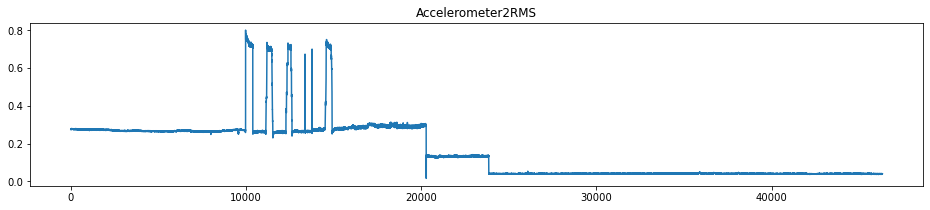

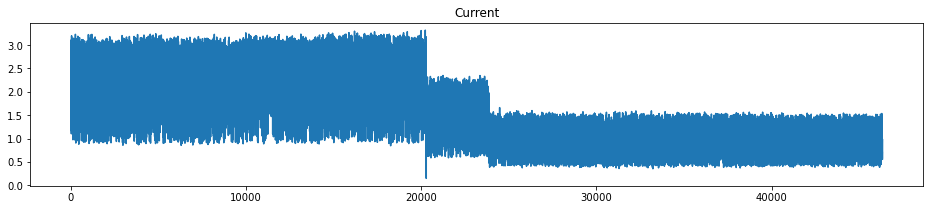

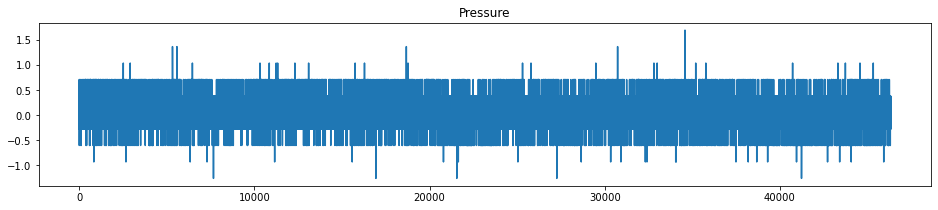

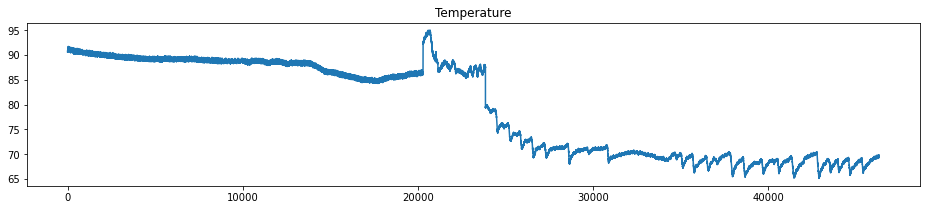

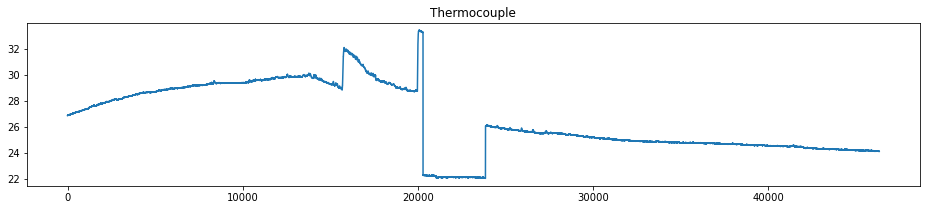

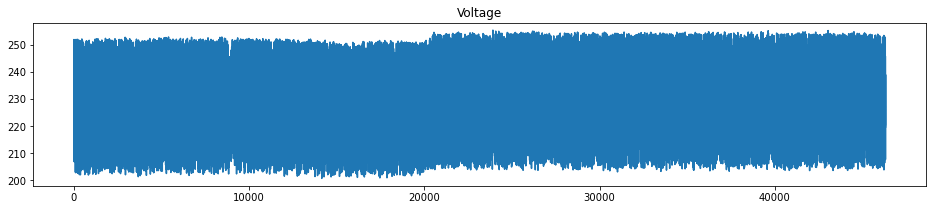

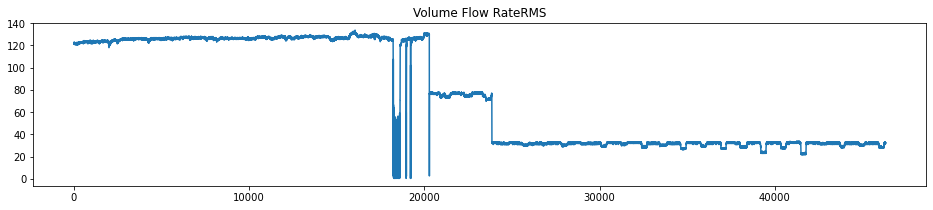

In [11]:
for column in all_data.columns[:-2]:
    plt.figure(figsize=(16, 3))
    plt.plot(all_data[column].values) #without gaps
    plt.title(column)
    plt.show()

<a id="2.3.3"></a>
### 2.3.3 Pairwise Correlations
Pairwise correlation information can often be used to search for relationships between features.

__Data without anomalies:__

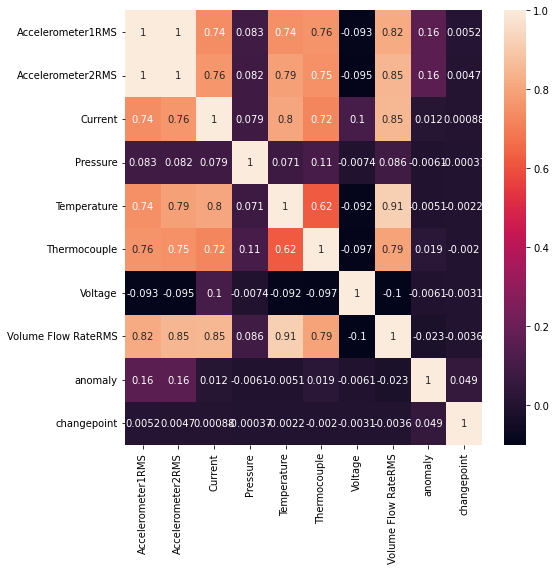

In [12]:
plt.figure(figsize=(8, 8))
display(Markdown('__Data without anomalies:__'))
sns.heatmap(all_data.corr(), annot = True, fmt='.2g');

<a id="2.3.4"></a>
### 2.3.4 Pairplot
To search for relationships between features, you can also use the pairplot function from the seaborn library, which combines all possible scatterplots and histograms

Wall time: 2.36 s


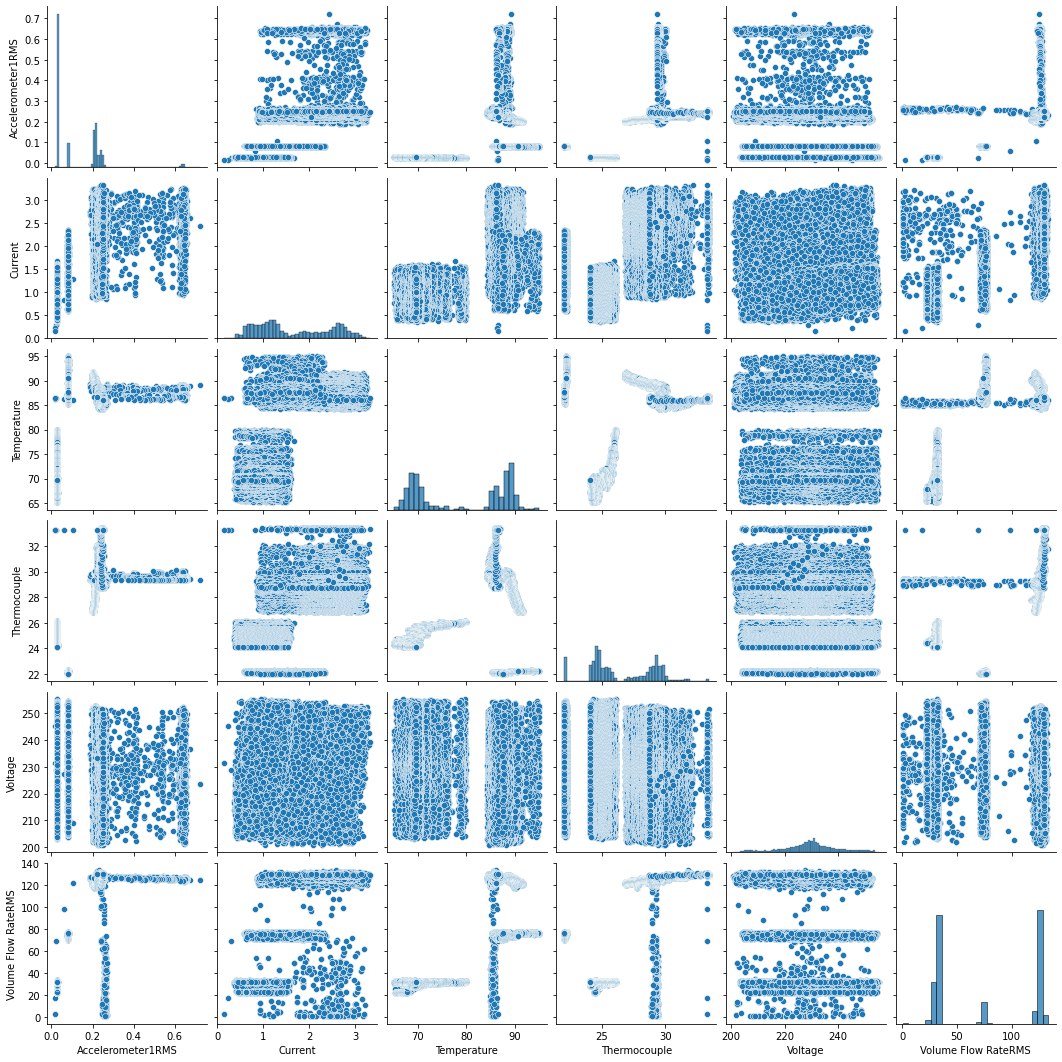

In [13]:
%%time
features = ['Accelerometer1RMS', 'Current', 'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']
sns.pairplot(all_data.reset_index()[features]);


<a id="2.3.5"></a>
### 2.3.5 Distribution plot

First of all, for the analysis of parameters, it is useful to look at the distribution of values using a histogram

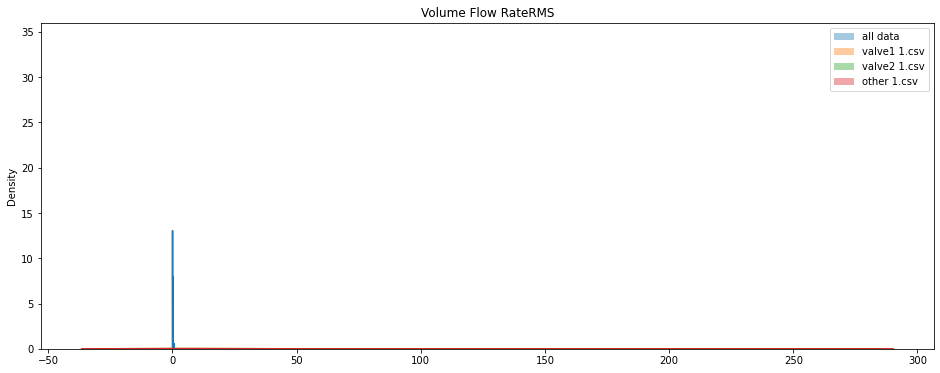

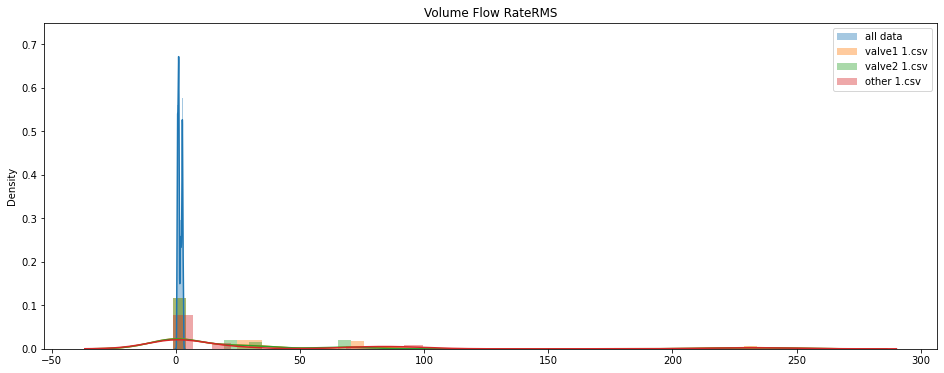

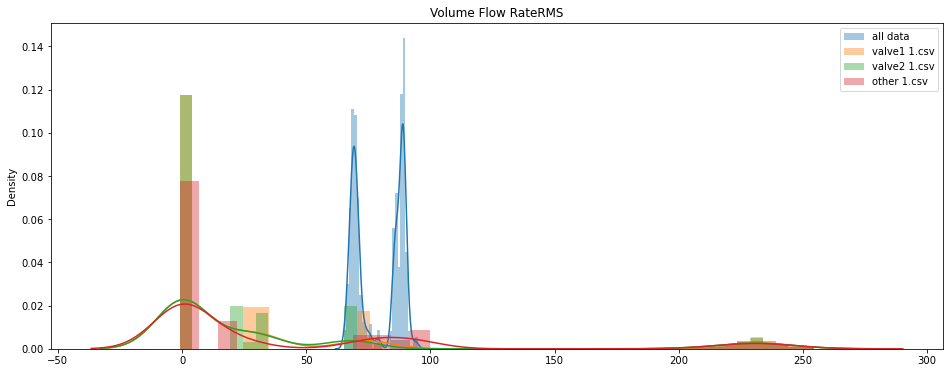

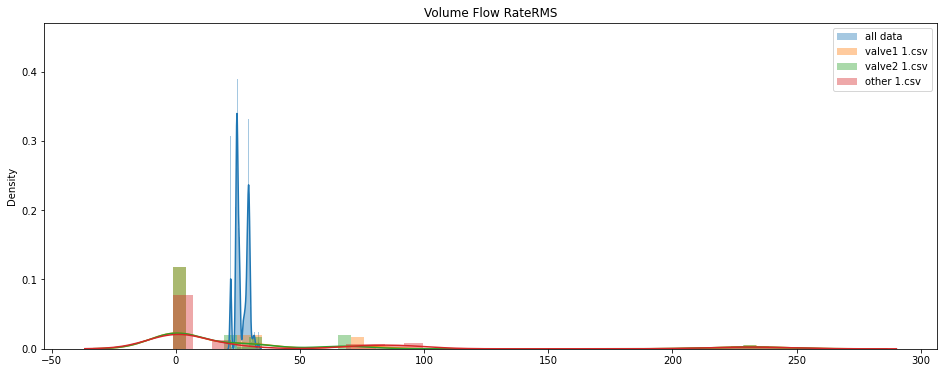

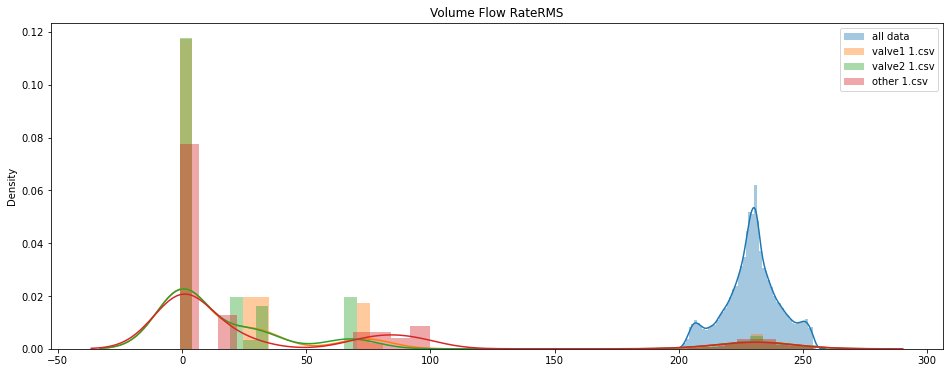

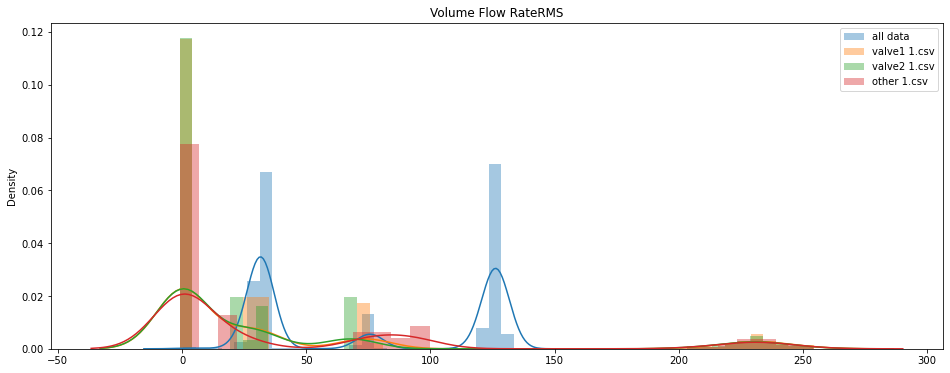

In [14]:
bins = None
for col in features:
    plt.figure(figsize=(16, 6))
    sns.distplot(all_data[col].values,bins=bins,label='all data') #without gaps  
    sns.distplot(valve1_data['1.csv'].values,bins=bins,label='valve1 1.csv') #without gaps  
    sns.distplot(valve2_data['1.csv'].values,bins=bins,label='valve2 1.csv') #without gaps  
    sns.distplot(other_data['1.csv'].values,bins=bins,label='other 1.csv') #without gaps  
    plt.title(column)
    plt.legend()
    plt.show()
# all_data = pd.concat(([anomaly_free_data] + list(valve1_data.values()) + list(valve2_data.values()) + list(other_data.values())),
#                      0).sort_index().drop_duplicates()